In [150]:
# initialization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
import re
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import time

nltk.download('punkt')
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/fionchai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fionchai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

In [151]:
%%script false --no-raise-error # comment this if you dont have the dev_set

# import dataset
train_set = pd.read_csv('train.csv')

test_set = pd.read_csv('test.csv')

# from train_set sample development set
dev_set = train_set.sample(n=500, replace=False)

# remove dev set from train set
train_set = train_set.drop(dev_set.index)

# check
print(train_set.shape, dev_set.shape, test_set.shape)

# save to dataframe
dev_set.to_csv("dev_set.csv", index=False)
train_set.to_csv("train_set_modified.csv", index=False)

In [152]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

## Preprocess data


In [153]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

In [154]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [155]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [156]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [157]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [158]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)

  x = torch.tensor(np.array(padded_sentences))

  return x


### Prepare data for training and testing

In [159]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)
test_set = encode_y_label(test_set, 5)

In [195]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

X_test = preprocess_x(test_set)
y_test = test_set['encoded-coarse-label']

# mini-batch strategy
batch_size = 32

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)
test_data = CustomDataset(X_test, y_test)

/var/folders/s6/9xhy3ssd0snfcfh5ys7848y40000gn/T/ipykernel_40363/1626110238.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


##  LSTM model

In [161]:
HIDDEN_SIZE = 128
OUTPUT_SIZE = 5
NUM_LAYERS = 1


class simple_lstm(nn.Module):
    def __init__(
                    self,
                    input_size = 300,
                    hidden_size= HIDDEN_SIZE,
                    output_size= OUTPUT_SIZE,
                    num_layers= NUM_LAYERS,
                   # dropout_rate= 0.2,
                    bidirectional= True,
                ):

        super().__init__()
        # Model body
        self.lstm = nn.LSTM(input_size= input_size, hidden_size= hidden_size, bidirectional= bidirectional, num_layers= num_layers, batch_first= True)

        # Model head
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * hidden_size, output_size),
           # nn.Dropout(dropout_rate),
            nn.Softmax(dim= 2)
        )

    def __call__(self, input):
        out, _ = self.lstm(input) # out dim = 32 x max_length x 256

        #  apply max pooling along the sequence dimension
        pooled_output = F.max_pool2d(out, kernel_size=(out.size(1), 1), stride=(out.size(1), 1)) # pooled output dim = 32 x 1 x 256, out.size(1) to match max_length of dataset
        
        return self.head(pooled_output) # expected dim = 32 x 1 x 5

## Find optimal batch size

In [162]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
model = simple_lstm(input_dim, 128, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [163]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [164]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  model = simple_lstm(input_dim, 128, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break 
      
  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time 
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.31112
Epoch: 0, dev set loss: 1.18629
Accuracy: 72.60%
Epoch: 1, training set loss: 1.20371
Epoch: 1, dev set loss: 1.16453
Accuracy: 73.40%
Epoch: 2, training set loss: 1.15417
Epoch: 2, dev set loss: 1.12816
Accuracy: 77.20%
Epoch: 3, training set loss: 1.12428
Epoch: 3, dev set loss: 1.14349
Accuracy: 75.60%
Epoch: 4, training set loss: 1.10002
Epoch: 4, dev set loss: 1.15411
Accuracy: 75.40%
Epoch: 5, training set loss: 1.08448
Epoch: 5, dev set loss: 1.10939
Accuracy: 79.00%
Epoch: 6, training set loss: 1.06187
Epoch: 6, dev set loss: 1.11493
Accuracy: 78.40%
Epoch: 7, training set loss: 1.05146
Epoch: 7, dev set loss: 1.11090
Accuracy: 79.20%
Epoch: 8, training set loss: 1.03764
Epoch: 8, dev set loss: 1.11963
Accuracy: 78.00%
Epoch: 9, training set loss: 1.02857
Epoch: 9, dev set loss: 1.13369
Accuracy: 76.20%
Epoch: 10, training set loss: 1.01850
Epoch: 10, dev set loss: 1.10940
Accuracy: 78.60%
Epoch: 11, training set loss: 1.00446
Epoch: 11, dev

In [165]:
accuracy_list_batch_size

{2: 0.7827,
 4: 0.7918999999999999,
 8: 0.767,
 16: 0.7753,
 24: 0.7705000000000002,
 32: 0.7537,
 64: 0.7414,
 128: 0.7215,
 256: 0.6832,
 512: 0.626}

Text(0.5, 1.0, 'Accuracy against Batch size')

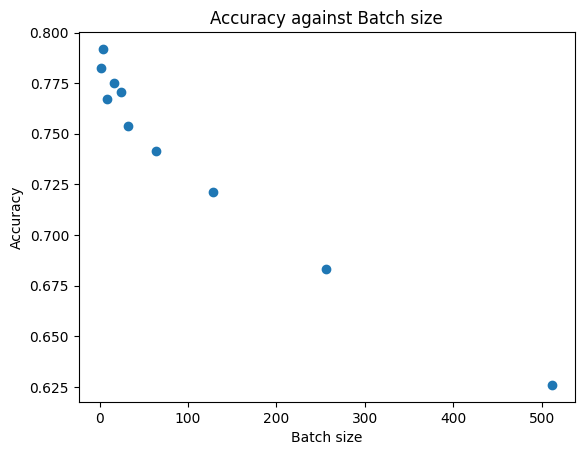

In [166]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

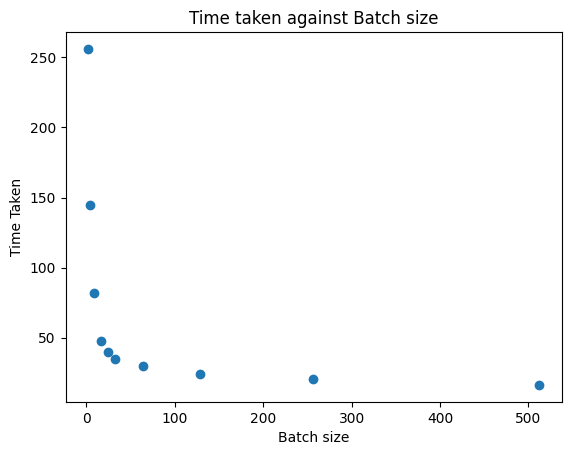

In [167]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")

Text(0.5, 1.0, 'Loss against Batch size')

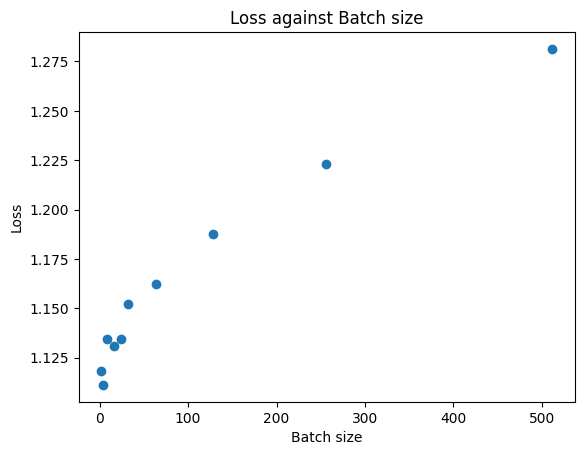

In [168]:
# Plot dev loss against batch size
plt.scatter(loss_batch_size.keys(), loss_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Loss against Batch size")

Based on the result shown above, batch size of 24 is chosen for it's accuracy and time taken.

## Find optimal number of hidden layers

In [169]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_size = 24
num_layers = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [170]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_num_layers = {}
time_taken_num_layers = {}
loss_num_layers = {}

for layer in num_layers:
  model = simple_lstm(input_dim, 128, 5, layer)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_num_layers[layer] =  end_time - start_time 
  accuracy_list_num_layers[layer] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_num_layers[layer] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.46421
Epoch: 0, dev set loss: 1.35046
Accuracy: 57.20%
Epoch: 1, training set loss: 1.27902
Epoch: 1, dev set loss: 1.22225
Accuracy: 68.20%
Epoch: 2, training set loss: 1.19154
Epoch: 2, dev set loss: 1.16419
Accuracy: 73.80%
Epoch: 3, training set loss: 1.15122
Epoch: 3, dev set loss: 1.18447
Accuracy: 72.40%
Epoch: 4, training set loss: 1.12061
Epoch: 4, dev set loss: 1.14175
Accuracy: 76.20%
Epoch: 5, training set loss: 1.09966
Epoch: 5, dev set loss: 1.13055
Accuracy: 78.20%
Epoch: 6, training set loss: 1.07835
Epoch: 6, dev set loss: 1.13527
Accuracy: 76.00%
Epoch: 7, training set loss: 1.06204
Epoch: 7, dev set loss: 1.13319
Accuracy: 77.00%
Epoch: 8, training set loss: 1.05139
Epoch: 8, dev set loss: 1.12687
Accuracy: 78.00%
Epoch: 9, training set loss: 1.03977
Epoch: 9, dev set loss: 1.11769
Accuracy: 78.40%
Epoch: 10, training set loss: 1.03054
Epoch: 10, dev set loss: 1.13758
Accuracy: 76.20%
Epoch: 11, training set loss: 1.02400
Epoch: 11, dev

In [171]:
accuracy_list_num_layers

{1: 0.7564,
 2: 0.7445999999999999,
 3: 0.6564,
 4: 0.4758,
 5: 0.44700000000000006,
 6: 0.3402000000000001}

Text(0.5, 1.0, 'Accuracy against Number of Layers')

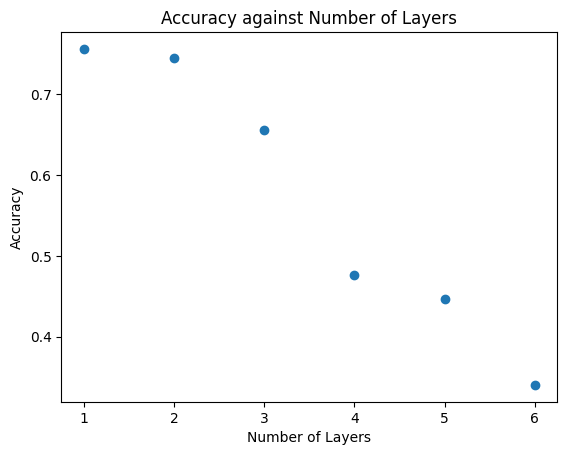

In [172]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_num_layers.keys(), accuracy_list_num_layers.values())
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Layers")

Text(0.5, 1.0, 'Time taken against Number of Layers')

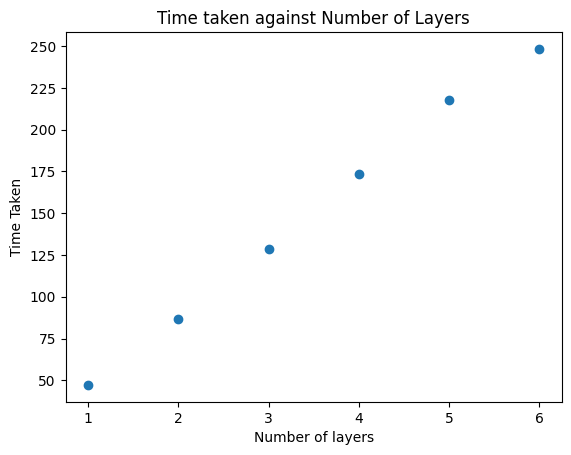

In [173]:
# Plot dev time against batch size
plt.scatter(time_taken_num_layers.keys(), time_taken_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Layers")

Text(0.5, 1.0, 'Loss against Number of Layers')

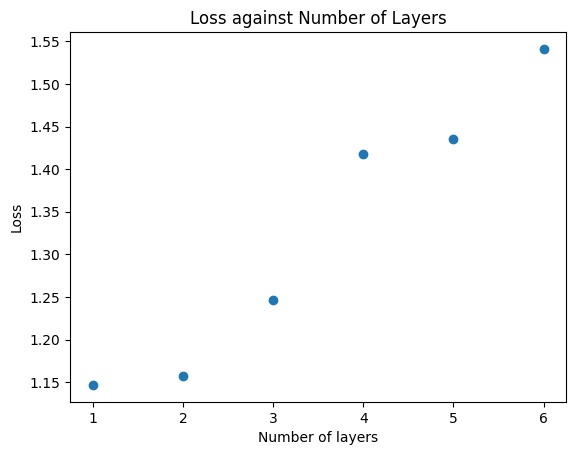

In [174]:
# Plot dev loss against batch size
plt.scatter(loss_num_layers.keys(), loss_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Loss")
plt.title("Loss against Number of Layers")

As seen in the result, having 1 hidden layer results in the highest accuracy and shortest time taken. Hence, 1 hidden layer is used.

## Find optimal number of hidden neurons

In [175]:
input_dim = embed_shape
hidden_dims = [64, 138, 256, 512]
output_dim = 5
layer_dim = 300
batch_size = 24
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [176]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_hidden_dims = {}
time_taken_hidden_dims = {}
loss_hidden_dims = {}

for hidden_dim in hidden_dims:
  model = simple_lstm(input_dim, hidden_dim, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_hidden_dims[hidden_dim] =  end_time - start_time 
  accuracy_list_hidden_dims[hidden_dim] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_hidden_dims[hidden_dim] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.47909
Epoch: 0, dev set loss: 1.35092
Accuracy: 54.00%
Epoch: 1, training set loss: 1.29348
Epoch: 1, dev set loss: 1.21823
Accuracy: 71.80%
Epoch: 2, training set loss: 1.20181
Epoch: 2, dev set loss: 1.20737
Accuracy: 70.00%
Epoch: 3, training set loss: 1.16790
Epoch: 3, dev set loss: 1.17152
Accuracy: 72.80%
Epoch: 4, training set loss: 1.14628
Epoch: 4, dev set loss: 1.15336
Accuracy: 75.00%
Epoch: 5, training set loss: 1.12252
Epoch: 5, dev set loss: 1.13982
Accuracy: 76.40%
Epoch: 6, training set loss: 1.10585
Epoch: 6, dev set loss: 1.13908
Accuracy: 76.40%
Epoch: 7, training set loss: 1.09218
Epoch: 7, dev set loss: 1.14214
Accuracy: 76.00%
Epoch: 8, training set loss: 1.07822
Epoch: 8, dev set loss: 1.14436
Accuracy: 75.40%
Epoch: 9, training set loss: 1.06878
Epoch: 9, dev set loss: 1.13022
Accuracy: 77.40%
Epoch: 10, training set loss: 1.06090
Epoch: 10, dev set loss: 1.13216
Accuracy: 77.00%
Epoch: 11, training set loss: 1.04835
Epoch: 11, dev

In [177]:
accuracy_list_hidden_dims

{64: 0.7535999999999999,
 138: 0.7603000000000001,
 256: 0.7705,
 512: 0.7637000000000002}

Text(0.5, 1.0, 'Accuracy against Number of Hidden Neurons')

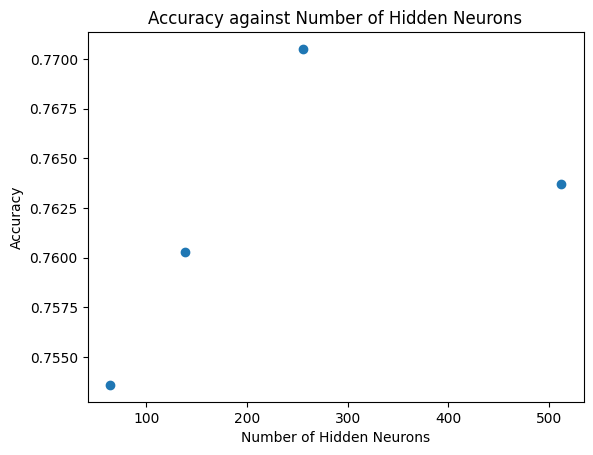

In [178]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_hidden_dims.keys(), accuracy_list_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Hidden Neurons")

Text(0.5, 1.0, 'Time taken against Number of Hidden Neurons')

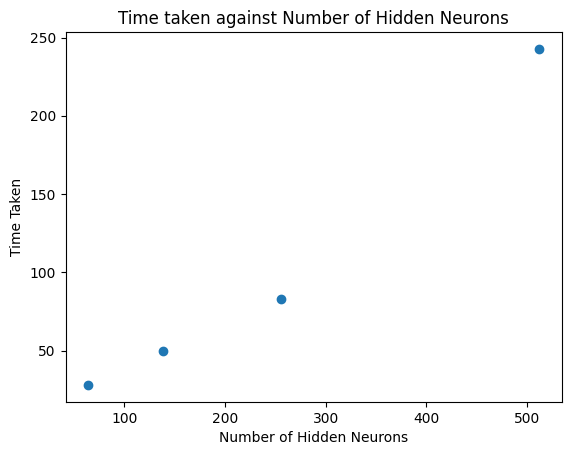

In [179]:
# Plot dev time against batch size
plt.scatter(time_taken_hidden_dims.keys(), time_taken_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Hidden Neurons")

Text(0.5, 1.0, 'Loss against Number of Hidden Neurons')

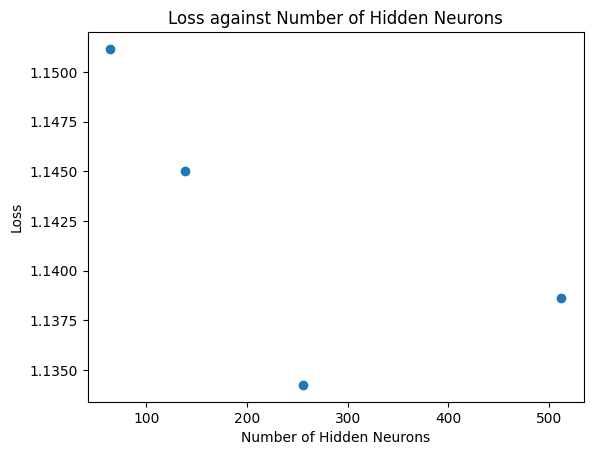

In [180]:
# Plot dev loss against batch size
plt.scatter(loss_hidden_dims.keys(), loss_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Loss")
plt.title("Loss against Number of Hidden Neurons")

As model with 256 neurons results in the highest accuracy, 256 neurons are used.

## Final model training

In [181]:
model = simple_lstm(input_dim, 256, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(train_data, batch_size=24, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=24, shuffle=True)

In [182]:
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
dev_accuracy_list = []

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0

  for x_batch, y_batch in train_loader:
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        break


Epoch: 0, training set loss: 1.41386
Epoch: 0, dev set loss: 1.24375
Accuracy: 67.00%
Epoch: 1, training set loss: 1.22139
Epoch: 1, dev set loss: 1.17026
Accuracy: 74.60%
Epoch: 2, training set loss: 1.16762
Epoch: 2, dev set loss: 1.15580
Accuracy: 75.40%
Epoch: 3, training set loss: 1.14037
Epoch: 3, dev set loss: 1.13301
Accuracy: 78.00%
Epoch: 4, training set loss: 1.10902
Epoch: 4, dev set loss: 1.12799
Accuracy: 77.80%
Epoch: 5, training set loss: 1.09507
Epoch: 5, dev set loss: 1.13616
Accuracy: 77.20%
Epoch: 6, training set loss: 1.07768
Epoch: 6, dev set loss: 1.11237
Accuracy: 78.80%
Epoch: 7, training set loss: 1.06015
Epoch: 7, dev set loss: 1.11895
Accuracy: 78.60%
Epoch: 8, training set loss: 1.05477
Epoch: 8, dev set loss: 1.11449
Accuracy: 78.80%
Epoch: 9, training set loss: 1.05462
Epoch: 9, dev set loss: 1.10844
Accuracy: 79.40%
Epoch: 10, training set loss: 1.03542
Epoch: 10, dev set loss: 1.11548
Accuracy: 78.80%
Early stopping after 10 epochs.


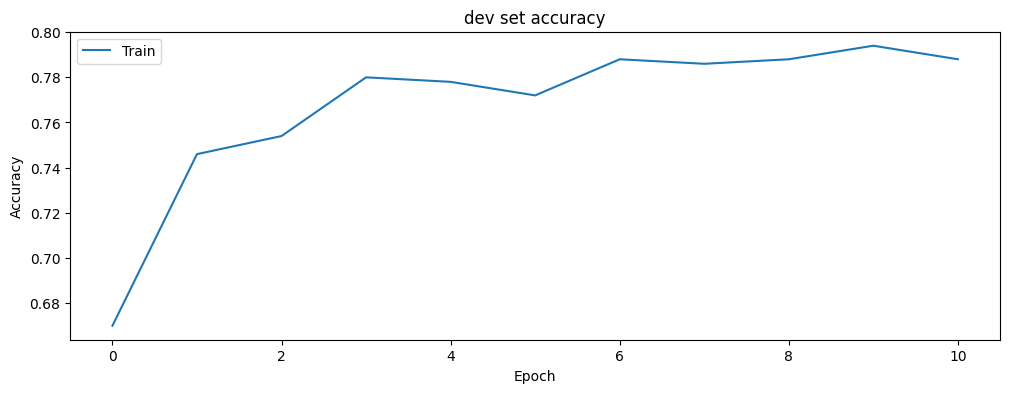

In [183]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('dev set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Using test set

In [201]:
print(x_batch, y_batch)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0520,  0.0698,  0.0986,  ...,  0.1553,  0.0053, -0.1128],
         [-0.0214,  0.0593,  0.0327,  ..., -0.0311,  0.0452, -0.1128]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.1099,  0.1846, -0.1187,  ..., -0.0591, -0.1875,  0.0442],
         [ 0.1226, -0.0894,  0.0270,  ..., -0.0640, -0.0718, -0.1387],
         [-0.0645,  0.0442,  0.0977,  ..., -0.0275, -0.0075, -0.3027]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [206]:
model.eval()
with torch.no_grad():
  all_true_labels = []
  all_predicted_labels = []
  total_test_loss = 0

  test_loader = DataLoader(test_data, shuffle=True)

  for X, y in test_loader:
    # forward pass
    y_pred = model(X.float())
    loss = criterion(y_pred.squeeze(1), y)

    total_test_loss += loss.item()

    predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

    y_batch = torch.argmax(y, dim=1)

    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(predicted_labels.tolist())

  average_test_loss = total_test_loss
  print(f"Average loss: {average_test_loss}")

accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
print(f"Accuracy: {accuracy * 100:.2f}%")

Average loss: 561.3153231143951
Accuracy: 77.60%
